Кирилл Лалаянц, R33352

# Лабораторная работа No8
# В -- 11
## Модальные регуляторы и наблюдатели

Импорт необходимых для работы библиотек. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
np.set_printoptions(precision=1)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Task1

In [2]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([[0], 
                    [2], 
                    [0], 
                    [9]])

task1_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task1_x0 = np.array([1, 1, 1, 1])

print(a2l.to_ltx(task1_specs, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -4.00 + 0.00j & -4.00 + 0.00j & -4.00 + 0.00j & -4.00 + 0.00j\\
 -4.00 + 0.00j & -40.00 + 0.00j & -400.00 + 0.00j & -400.00 + 0.00j\\
 -4.00 + 0.00j & -8.00 + 0.00j &  0.00 + 5.00j &  -0.00 + -5.00j\\
 -4.00 + 0.00j & -8.00 + 0.00j & -1.00 + 5.00j & -1.00 + -5.00j
\end{bmatrix}


In [3]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    return - Y @ np.linalg.pinv(P.value)

def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    return new_g

def task1_get_G_bad(specs):
    base = []
    for i in range(len(specs)):
        rolled = np.array(np.roll([i + 1 for i in range(len(specs))], i))
        base.append(rolled)
    base = np.array(base)
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
            if new_g[i, i] == new_g[i-1, i-1]:
                new_g[i-1, i] = 1
    if specs[2].imag != 0:
            new_g[2, 2] = specs[2].real
            new_g[3, 3] = specs[2].real
            new_g[2, 3] = specs[2].imag
            new_g[3, 2] = -specs[2].imag
        
    new_g = base @ new_g @ np.linalg.inv(base)
    return new_g
    
    
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}')
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

In [4]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable



======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Optimization error: 4.2401273655629385e-30, rankP = 3
RankV = 3
Eigen values of A:
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
K = [[-1.1e-14 -2.5e+00 -1.1e+00 -1.1e+00]]
\begin{bmatrix}
 -0.00 & -2.50 & -1.11 & -1.11
\end{bmatrix}
spec(A + B@K): [-4.+0.j -4.-0.j -4.+0.j -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Optimization error: 1.622191532857925e-29, rankP = 3
RankV = 3
Eigen values of A:
   [-4.+0.j]: not observable
   [-40.+0.j]: observable
   [-400.+0.j]: observable
   [-400.+0.j]: observable
K = [[      0.  -131856.8   -4303.5   29207.8]]
\begin{bmatrix}
  0.00 & -131856.82 & -4303.51 &  29207.85
\end{bmatrix}
spec(A + B@K): [-400. -400.  -40.   -4.]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Optimization error: 3.870348816240589e-29, rankP = 3
RankV = 3
Eigen values of A:
   [0.+5.j]: observable
   [-2.2e-16-5.j]: observable
   [-4.+0.j]: not observable
   [-8.+0.j]: observable
K = [[ 0.  -4.7 -0.4 -0.2]]
\begin{bmatrix}
  0.00 & -4.68 & -0.42 & -0.18
\end{bmatrix}
spec(A + B@K): [ 1.7e-15+5.j  1.7e-15-5.j -8.0e+00+0.j -4.0e+00+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Optimization error: 1.9721522630525295e-29, rankP = 3
RankV = 3
Eigen values of A:
   [-1.+5.j]: observable
   [-1.-5.j]: observable
   [-4.+0.j]: not observable
   [-8.+0.j]: observable
K = [[ 0.  -5.2 -0.9 -0.3]]
\begin{bmatrix}
  0.00 & -5.22 & -0.89 & -0.28
\end{bmatrix}
spec(A + B@K): [-1.+5.j -1.-5.j -8.+0.j -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


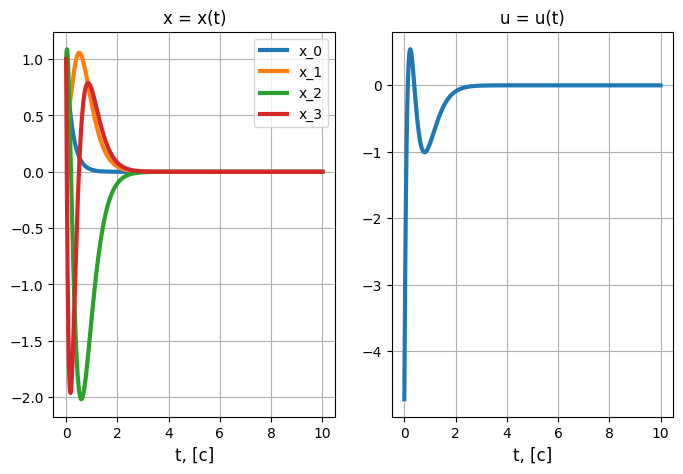

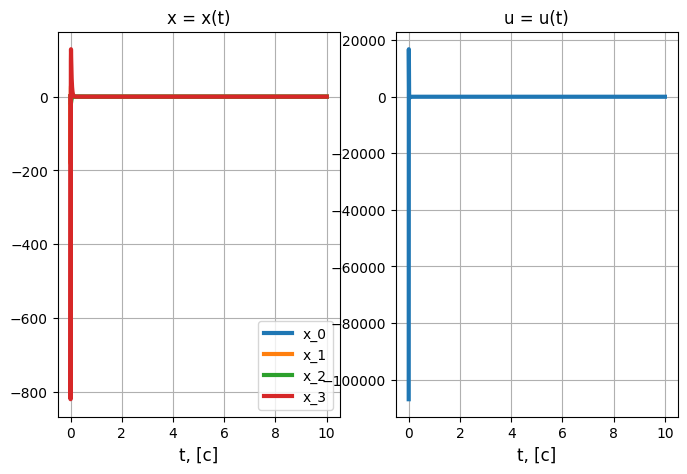

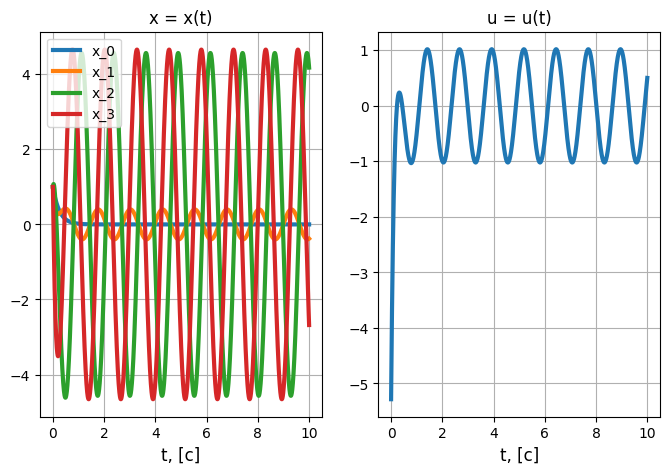

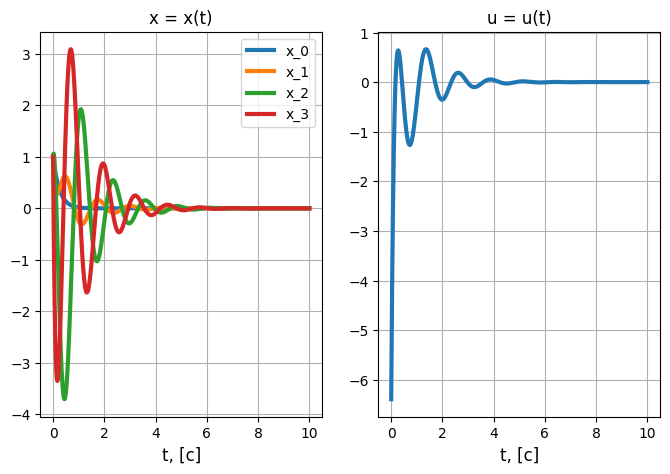

In [5]:
for indx, specs in enumerate(task1_specs):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    new_y = np.ones((task1_B.shape[1], task1_A.shape[0]))
    new_y[0, 0] = 0
    # print(f'G:\n{new_g}')
    # print(f'Y:\n{new_y}')
    
    K = task1_get_K(task1_A, task1_B, new_g, new_y).astype(np.float64)
    check_observability(new_y, new_g)
    check_observability_eigens(new_y, new_g)
    
    print(f'K = {K}')
    print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    
    ts = get_t(10)
    res = task1_simulate(task1_A, task1_B, K, task1_x0, ts)

    fig, axs = plt.subplots(1, 2, figsize=(8, 5))
    for i in range(4):
        axs[0].plot(ts, res.states[i], linewidth = 3, label='x_' +str(i))
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_title(f'x = x(t)', fontsize=12)
    axs[0].set_xlabel(f"t, [c]", fontsize=12)

    axs[1].plot(ts, (K @ res.states).reshape(-1), linewidth = 3)
    axs[1].grid(True)
    axs[1].set_title(f'u = u(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    plt.savefig(f'{SAVE_PATH}/task1_{indx}.jpg')

## Task 2

In [6]:
task2_A = np.array([
    [0, 4, 0, 0],
    [-4, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0]
])

task2_C = np.array([[5, 0, 0, 9]])

task2_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task2_x0 = np.array([1, 1, 1, 1])
task2_xh0 = np.array([2, 0, 0, -1])

In [7]:
np.zeros((task2_A.shape[0], 1))

array([[0.],
       [0.],
       [0.],
       [0.]])

In [34]:
def task2_simulate(A, C, L, x0, xh0, ts):
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, L, A*0, L*0)
    return original_resp, control.forced_response(ss, X0=xh0, T=ts, U=original_resp.outputs.reshape(-1))

def task2_get_L(A, C, G, Y):
    Q = cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(Q.value)}')
    return np.linalg.pinv(Q.value) @ Y

In [35]:
check_observability_eigens(task2_C, task2_A)

Eigen values of A:
   [0.+4.j]: observable
   [0.-4.j]: observable
   [0.+3.j]: observable
   [0.-3.j]: observable


In [50]:
for indx, specs in enumerate(task1_specs):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    new_y = np.ones((task1_A.shape[0], task2_C.shape[0]))
    
    L = task2_get_L(task2_A, task2_C, new_g, new_y).astype(np.float64)
    check_controllability(new_g, new_y)
    check_controllability_eigens(new_g, new_y)
    
    print(f'L = {L}')
    print(a2l.to_ltx(L.T, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    print(np.linalg.eigvals(task2_A + L @ task2_C))
    
    ts = get_t(10)
    original_resp, observer_resp = task2_simulate(task2_A, task2_C, L, task2_x0, task2_xh0, ts)

    fig, axs = plt.subplots(2, 2, figsize=(16, 6))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(original_resp.states.shape[0]):
        axs[i//2, i % 2].plot(ts, original_resp.states[i], color='r', linewidth=4, label='system')
        axs[i//2, i % 2].plot(ts, -observer_resp.states[i], '--', color='g', linewidth = 2, label='observer')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
    plt.savefig(f'{SAVE_PATH}/task2_states_{indx}.jpg')
    plt.close()

    plt.plot(ts, original_resp.outputs.reshape(-1), linewidth = 3, label='system')
    plt.plot(ts, -(task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label='observer')
    plt.plot(ts, original_resp.outputs.reshape(-1) + (task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label='error')
    
    plt.grid(True)
    plt.legend()
    plt.title(f'y = y(t)', fontsize=12)
    plt.xlabel(f"t, [c]", fontsize=12)
    plt.savefig(f'{SAVE_PATH}/task2_y_{indx}.jpg')
    plt.close()


======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Optimization error: 7.888609052210118e-31, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
L = [[ 1.0e-12]
 [-7.3e+00]
 [-2.8e+00]
 [-1.8e+00]]
\begin{bmatrix}
  0.00 & -7.31 & -2.79 & -1.78
\end{bmatrix}
[-4.+0.j -4.-0.j -4.+0.j -4.-0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Optimization error: 1.581429225584969e-30, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-40.+0.j]: controllable
   [-400.+0.j]: controllable
   [-400.+0.j]: controllable
L = [[ 204414.2]
 [ 160532.1]
 [ 126147.3]
 [-113657.2]]
\begin{bmatrix}
  204414.17 &  160532.11 &  126147.31 & -113657.21
\end{bmatrix}
[-400.+0.j -400.-0.j  -40.+0.j   -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Optimization error: 7.099748146989106e-30, rankP = 4
RankU = 4
Eigen values of A:
   [0.+5.j]: controllable
   [-2.2e-16-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 3.1]
 [ 1. ]
 [ 1.9]
 [-3. ]]
\begin{bmatrix}
  3.09 &  1.03 &  1.95 & -3.05
\end{bmatrix}
[-3.8e-15+5.j -3.8e-15-5.j -8.0e+00+0.j -4.0e+00+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)



======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Optimization error: 1.4396711520283465e-29, rankP = 4
RankU = 4
Eigen values of A:
   [-1.+5.j]: controllable
   [-1.-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 4.3]
 [-1.6]
 [ 0.9]
 [-4. ]]
\begin{bmatrix}
  4.34 & -1.60 &  0.93 & -3.97
\end{bmatrix}
[-8.+0.j -1.+5.j -1.-5.j -4.+0.j]


/Users/lalayants/.pyenv/versions/3.10.9/envs/control-theory-itmo/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
